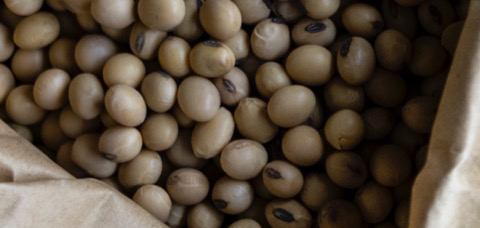

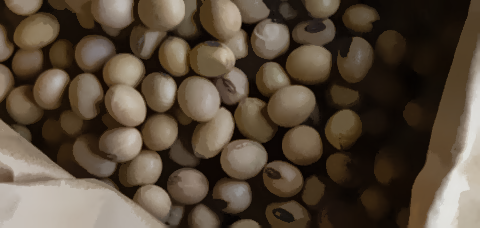

In [1]:
import cv2
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

def url_to_image(url):
  return cv2.cvtColor(io.imread(url), cv2.COLOR_BGR2RGB)

url2 = "https://raw.githubusercontent.com/mdavydov/ComputerVisionCourse/master/tasks/count/count4.jpg"


img = url_to_image(url2)
cv2_imshow(img)
shifted = cv2.pyrMeanShiftFiltering(img, 11, 21)
cv2_imshow(shifted)


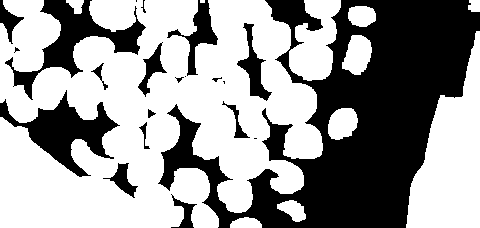

In [2]:
gray = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 70, 255,
	cv2.THRESH_BINARY)[1]

kernel = np.ones((5,5), np.uint8) 
thresh = cv2.dilate(thresh, kernel, iterations=1) 

cv2_imshow(thresh)

[INFO] 11 unique contours found


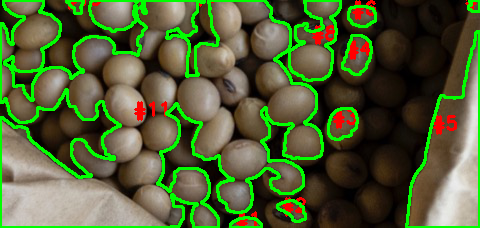

In [3]:
import imutils
# find contours in the thresholded image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
print("[INFO] {} unique contours found".format(len(cnts)))

image = img.copy()

# loop over the contours
for (i, c) in enumerate(cnts):
	# draw the contour
	((x, y), _) = cv2.minEnclosingCircle(c)
	cv2.putText(image, "#{}".format(i + 1), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
	cv2.drawContours(image, [c], -1, (0, 255, 0), 2)
 
# show the output image
cv2_imshow(image)

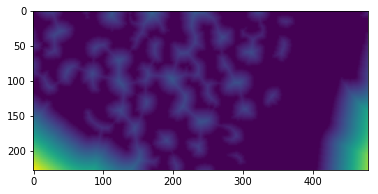

In [4]:
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

D = ndimage.distance_transform_edt(thresh)
plt.imshow(D)

[INFO] 27 unique segments found


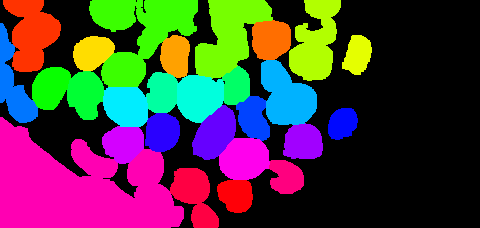

In [5]:
localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=thresh)
 
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=thresh)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

label_hue = np.uint8(179*labels/np.max(labels))
blank_ch = 255*np.ones_like(label_hue)
labeled_img = cv2.merge([label_hue, blank_ch, blank_ch])

# cvt to BGR for display
labeled_img = cv2.cvtColor(labeled_img, cv2.COLOR_HSV2BGR)

# set bg label to black
labeled_img[label_hue==0] = 0

#cv2_imshow(img)
cv2_imshow(labeled_img)

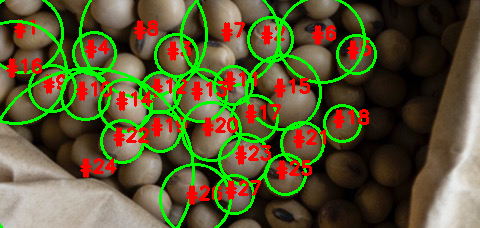

In [6]:
# loop over the unique labels returned by the Watershed
# algorithm
image = img

for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
 
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255 
	#cv2_imshow(mask)#[labels == label] = 255   
  # detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
 
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
 
# show the output image
cv2_imshow(image)